In [2]:
import pandas as pd
import  numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [3]:
bureau = pd.read_csv('./bureau.csv')


In [4]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [5]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index = False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU':'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [6]:
train = pd.read_csv('./application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

#NAN 값에 0을 대입
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### R value를 활용한 변수 유용성 평가

새롭게 생성된 Column의 변수들이 유용한지 판단하기 위해, 우선 목표값(target)과 해당 변수간의 피어슨 상관계수 (Pearson Correlation Coefficient, r-value)를 계산하고자 합니다. 두 변수 사이의 선형관계(linear relationship)는 -1(완벽하게 음의 선형관계)에서부터 +1(완벽히 양의 선형관계) 사이의 값으로 표현됩니다. r-value가 변수의 유용성을 평가하기 위한 최선의 방식은 아니지만, 머신러닝 모델을 발전시키는데 효과가 있을 지에 대한 대략적인 정보를 줄 수 있습니다. 목표값에 대한 r-value가 커질 수록, 해당 변수가 목표값에 영향을 끼칠 가능성이 높아집니다. 그러므로 목표값에 대해 가장 큰 r-value의 절댓값을 가지는 변수를 찾고자 합니다.

또한 우리는 커널밀도추정그래프(Kernal Density Estimate Plot)을 활용하여 목표값과의 상관관계를 시각적으로 살펴볼 것입니다.

### 커널밀도추정그래프(Kernal Density Esetimate Plots)

커널밀도추정그래프는 단일 변수의 분포를 보여줍니다.(히스토그램을 부드럽게한(smoothed) 것으로 생각해보면 될 것입니다.) 범주형 변수(Categorical Variable)의 값 차이에 따른 분포를 차이를 보기위해, 카테고리에 따라 색을 다르게 칠하도록 하겠습니다. 예를 들어, TARGET 값이 0인지 1인지에 따라 색을 다르게 칠한 previous_loan_count의 커널밀도추정그래프를 그릴 수 있습니다. 이러한 그래프는 대출을 상환한 그룹(TARGET==0)과 그렇지 못한 그룹(TARGET==1)의 분포에 있어 차이점들을 보여줄 것입니다. 이는 변수들이 머신러닝 모델과 관련성을 가지는 지를 보여줄 수있는 지표로 활용될 수 있습니다.

In [7]:
# 변수의 분포에 대한 그래프 target값에 따라 색을 달리하여 작성 
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    '''
    Args
    
    input:
    
    var_name = str, 변수가 되는 Column
    df : DataFrame, 대상 데이터프레임
    
    
    return: None
    
    '''
    
    # 새롭게 생성된 변수와 target간의 상관계수를 계산
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # 대출의 상환한 그룹과 그렇지 않은 그룹의 중간값(median)계산
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET']==0,var_name].median()
    avg_not_repaid = df.ix[df['TARGET']==1,var_name].median()
    
    plt.figure(figsize = (12,6))
    
    # target값에 따라 색을 달리하여 그래프 작성
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET']==0,var_name],label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET']==1,var_name],label = 'TARGET == 1')
    
    # 그래프 라벨링
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # 상관계수 출력
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    
    # 중간값 출력
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [8]:
train['EXT_SOURCE_3'] = train['EXT_SOURCE_3'].fillna(0)

The correlation between EXT_SOURCE_3 and the TARGET is -0.1196
Median value for loan that was not repaid = 0.2881
Median value for loan that was repaid =     0.4741


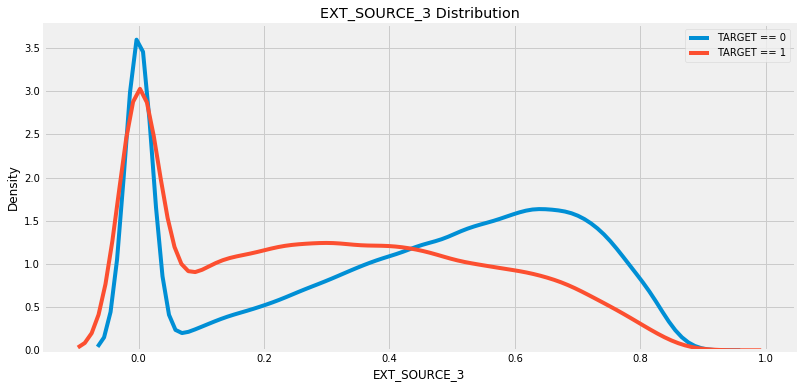

In [9]:
kde_target('EXT_SOURCE_3', train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


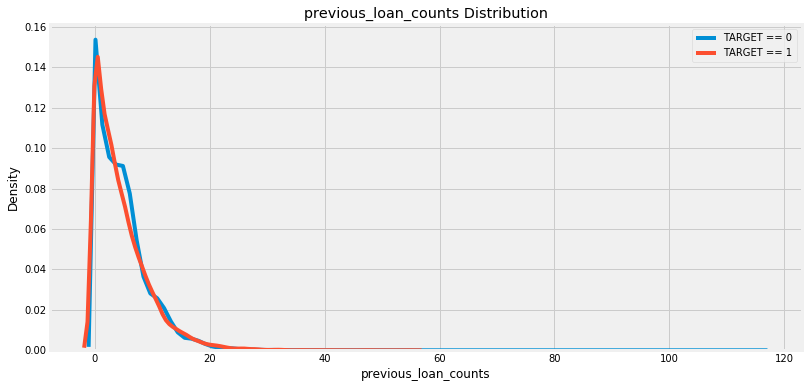

In [10]:
kde_target('previous_loan_counts',train)

previous_loan_counts가 별로 중요하지 않음을 알 수 있다. 상관계수가 너무 작으며,target값에 의한 분포의 차이도 별로 없다. 이제 bureau 데이터프레임으로부터 몇개의 변수들을 새롭게 생성해보자. bureau 데이터프레임의 모든 수치 데이터 column들로부터 평균, 최소, 최댓값을 가져오겠습니다.

### 수치 데이터들의 대푯값을 계산(Aggregating Numeric Columns)

(*agg를 활용하여 데이터프레임의 평균, 최대값, 최소값, 합계 등을 구하는 것을 대표값들을 계산한다고 번역하였습니다.)

bureau 데이터 프레임 안의 수치 데이터를 활용하기 위해, 모든 수치 데이터 Column의 대표값들을 계산할 것입니다. 이를 위해 고객 ID별로 그룹화(groupby)를 수행하고, 그룹화된 데이터프레임의 대표값들을 agg를 통해 구한 뒤, 결과를 훈련 데이터셋과 병합합니다. agg 함수는 오직 수치 데이터행들의 유효한 대표값들을 계산하는 역할을 수행합니다. 계속해서 mean, max, min, sum 함수를 기본으로 사용할 것이지만, 상황에 따라 어떠한 함수들은 생략될 수 있습니다. 또한, 별도의 함수를 작성한 후 이를 agg 함수를 통해 불러올 수 있습니다.

In [11]:
#고객 id에 따라 데이터프레임을 그룹화하고, 대푯값들을 계산
bureau_agg = bureau.drop(columns= ['SK_ID_BUREAU']).groupby('SK_ID_CURR',as_index = False).agg(['count','mean','max','min','sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

In [12]:
bureau.dtypes.value_counts()

float64    8
int64      6
object     3
dtype: int64

agg를 통해서 columns의 대푯값을 계산해 보여주는 bureau_agg를 만들었다. 데이터프레임의 types를 살펴봤을떄 61columns이므로 countm ,mean,max,min,sum 이 5개이므로 'SK_ID_CURR'을 제외한 60/5 인 12개의 column들에 대한 정보를 제공했다고 볼 수 있는데 dtype count해서 확인한 결과 object를 제외한 14개의 column 중 SK_ID_CURR과 ID_BUREAU를 제외한 수치를제공하는 12개 column에 관한것이다.

In [13]:
#Column 리스트를 생성
columns = ['SK_ID_CURR']

#변수(원본 데이터프레임의 column name)에 따라 반복문을 실행
for var in bureau_agg.columns.levels[0]:
    
    #id column은 생략
    if var != 'SK_ID_CURR':
        
        #대표값의 종류에 따라 반복문을 생성
        for stat in bureau_agg.columns.levels[1][:-1]:
            
            #변수 및 대표값의 종류에 따라 새로운 column name을 생성
            columns.append('bureau_%s_%s' %(var,stat))

In [14]:
bureau_agg.columns = columns #반복문을 통해 만든 columns를 데이터프레임의 column으로
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [15]:
#훈련데이터와 병합
train = train.merge(bureau_agg, on= 'SK_ID_CURR' , how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### 목표값과 대수값들의 상관계수 분석

In [16]:
#새로운 상관계수들에 대한 리스트를 생성
new_corrs = []

#columns별로 반복문을 실행
for col in columns:
    
    #TARGET과의 상관계수 계산
    corr = train['TARGET'].corr(train[col])
    
    #튜플(tuple)로 리스트에 추가
    new_corrs.append((col, corr))

In [17]:
new_corrs

[('SK_ID_CURR', -0.002108469018197718),
 ('bureau_DAYS_CREDIT_count', 0.004056091319389807),
 ('bureau_DAYS_CREDIT_mean', 0.08972896721998114),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997299),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_sum', 0.041999824814846716),
 ('bureau_CREDIT_DAY_OVERDUE_count', 0.004056091319389807),
 ('bureau_CREDIT_DAY_OVERDUE_mean', 0.008118453706602021),
 ('bureau_CREDIT_DAY_OVERDUE_max', 0.005492626487774548),
 ('bureau_CREDIT_DAY_OVERDUE_min', 0.007573067345301662),
 ('bureau_CREDIT_DAY_OVERDUE_sum', 0.006298260726499167),
 ('bureau_DAYS_CREDIT_ENDDATE_count', -0.0040022094250844725),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835494),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329094),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616024),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.0537348956010205),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325495),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758616)

sorted함수를 통해서 상관계수들을 절대값으로 정렬. lambada함수를 활용한다

In [18]:
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]),reverse = True)

In [19]:
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998114),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968673),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392077),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.0537348956010205),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758616),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997299),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115894),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835494),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730155),
 ('bureau_DAYS_CREDIT_sum', 0.041999824814846716),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306002),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329094),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616024),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325495)]

In [20]:
train['bureau_DAYS_CREDIT_mean'].fillna(np.nan)

0         -874.000000
1        -1400.750000
2         -867.000000
3                 NaN
4        -1149.000000
5         -757.333333
6        -1271.500000
7        -1939.500000
8        -1773.000000
9                 NaN
10       -1095.375000
11        -947.750000
12        -618.428571
13       -1944.333333
14                NaN
15        -495.000000
16        -261.500000
17                NaN
18        -337.000000
19       -1164.384615
20                NaN
21        -700.000000
22        -679.000000
23        -793.000000
24       -1416.750000
25        -930.833333
26        -579.571429
27       -1071.000000
28        -195.000000
29                NaN
             ...     
307481   -1053.000000
307482    -455.000000
307483   -1596.250000
307484            NaN
307485   -1839.000000
307486   -1254.833333
307487    -712.285714
307488    -529.500000
307489    -203.000000
307490    -756.600000
307491   -1785.000000
307492   -1270.153846
307493   -1430.000000
307494   -2157.833333
307495   -

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0928
Median value for loan that was not repaid = -903.2000
Median value for loan that was repaid =     -1140.3889


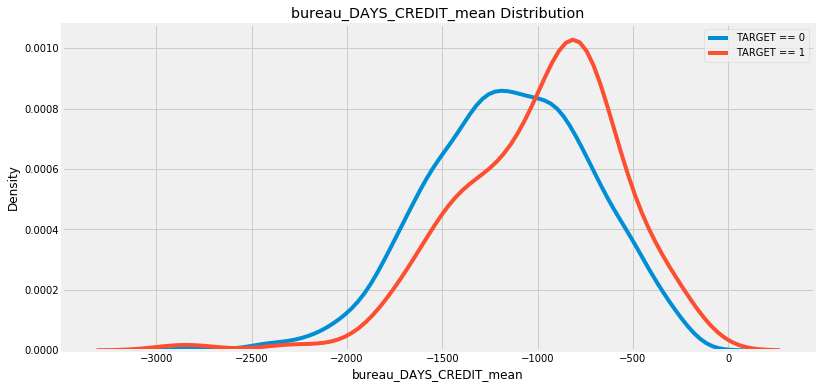

In [21]:
kde_target('bureau_DAYS_CREDIT_mean',train.dropna())


이 column은 '고객이 신용관리국 신용등급을 신청한 날로부터 현 대출신청까지 걸린 기간은 몇 일인가? (How many days before current application did client apply for Credit Bureau credit)'에 관한 데이터입니다. 이것을 이전 대출을 받고나서 'Home Credit'에서 대출을 받기전까지 걸린 일수(the number of days)로 해석하려 합니다. 그러므로, 마이너스 수치가 크다는 것은 이전 대출이 이루어진 시점이 더 오래됐음을 의미합니다. 여기서, 이 변수의 평균들과 목표값(target)이 매우 약한 양의 상관관계를 갖는 다는 것은 더 오래된 과거에 대출을 신청했던 고객들은 'Home Credit'에서 대출을 상환할 가능성이 높다는 것을 의미합니다. 그러나 이렇게 약한 상관관계는 그저 노이즈일 가능성도 있습니다.(With a correlation this weak though, it is just as likely to be noise as a signal.)

### 다중비교문제(the multiple comparisons problem)


변수가 매우 많을 때는, 다중비교문제로 알려진 우연에 의해 변수들이 목표값(target)에 대해 연관성을 가질 것으로 기대할 수 있습니다. 수백개의 특성(Feature)들을 만들 수 있지만, 몇개의 경우, 그저 데이터안의 랜덤하게 있는 노이즈값들에 의해 목표값(target)과 연관성을 가지는 것처럼 보일 수 있습니다. 이러한 변수들은 훈련 데이터상에서는 목표값과 관련성이 있는 것처럼 보이지만, 관련성들이 테스트 데이터까지 일반화될 수 없기 때문에 모델에 있어 오버피팅(과적합, overfit)을 야기할 수 있습니다. 그렇기에 Feature들을 만드는 것은 많은 고려가 필요합니다.

*(역자의 주) 여기서 다중비교문제란 한 가지 통계적 사실에 대해, 가설을 많이 세울수록 우연에 의해 가설을 충족시킬 결과를 얻을 확률이 높아지는 문제를 말합니다. 마치 원숭이한테 타자를 치라고하고, 유의미한 단어, 문장 등이 나올 때까지 프랑스어, 영어, 스페인어, 독일어 등등일 가설을 세운다면 언젠가는 원하는 결과가 나올 수 있는 것과 비슷한 거 같습니다.

예) 한 가지 약물의 효능을 질병의 여러 증상들 중 하나라도 개선시킬 수 있는 것으로 가정할 경우 : 질병의 증상을 더 많이 고려함에 따라 적어도 하나의 증상에 대해 효능을 가지는 것처럼 보일 가능성이 점점 높아짐. (출처 : Wikipedia, Multiple Comparisons Problem, 접속일 : 2019-05-30)

## 수치데이터의 대표값 연산을 위한 함수생성

In [22]:
def agg_numeric(df, group_var , df_name):
    '''
    데이터프레임안의 수치데이터에 한하여 대표값들을 계산합니다. 이것은 새로운 feature들을 만드는데 
    활용될 수 있습니다.
    
    파라미터(parameters)
    
            df(dataframe):연산의 대상이되는 데이터프레임
            group_var(string): 그룹화(groupby)의 기준이 되는 column
            df_name(string): column명을 재정의하는데 쓰이는 변수
            
    출력값(Returns)
    
            agg(dataframe)
    
    '''
    
    #그룹화대상이 아닌 id들을 제거
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
     # 특정 변수들을 그룹화하고 대표값들을 계산
    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count','mean','max','min','sum']).reset_index()
    
    # 새로운 column 이름들을 생성
    # Need to create new column names
    columns = [group_var]
    
    # 변수(원본 데이터프레임의 column name)에 따라 반복문을 실행
    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        
        # id column은 생략
        # skip the grouping variable
        if var != group_var:
            
            # 대표값의 종류에 따라 반복문을 생성
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
        
                # 변수 및 대표값의 종류에 따라 새로운 column name을 생성
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
                
    agg.columns = columns
    return agg

In [23]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### 상관관계 함수 생성

In [24]:
#데이터프레임상의 목표값(target)과의 상관계수를 계산하기 위한 함수

def target_corrs(df):
    corrs = []
    
    #column별로 반복문을 실행
    for col in df.columns:
        print(col)
        
        #target column은 생략
        if col != 'TARGET':
            
            #목표값(taret)과의 상관계수 계산
            corr = df['TARGET'].corr(df[col])
            
            #튜플(tuple)로 리스트에 추가
            corrs.append((col,corr))
            
    #상관계수들을 절대값 크기로 정렬
    corrs = sorted(corrs, key = lambda x : abs(x[1]),reverse = True)
    
    return corrs

## 범주형 데이터(Categorical values)

지금부터는 범주형(categorical) column들을 다뤄보도록 하겠습니다. 주로 문자열 데이터들로써, 이러한 데이터들에 대해서는 평균이나 최대치 등 통계를 활용하기가 어렵습니다. 그 대신, 각 범주별로 값들의 갯수를 셀 것입니다. 예를 들어, 우리가 아래와 같은 데이터프레임을 가지고 있다면 각 고객의 범주별 대출 갯수를 활용하여, 이런 정보를 만들어낼 것입니다. 
그 다음, 고객별 대출 횟수를 활용하여 값들을 정규화(normalize)할 것입니다. (고객별 대출 횟수의 합계를 1로하여 계산) (이 부분은 아래 표를 보고 해석하였습니다.)


원문의 표가 생략되었는데 SK_ID_CURR별로 Loan type을 categorize해서 credit count, cash count, home count 몇번 이렇게 만들고 total중에서 몇번인지 normalize 시켜서 총합이 1이 되는 count norm 변수를 만든다

다행히도, 이러한 방식으로 범주형 변수들을 인코딩(encoding)함으로써 데이터들이 담고 있는 정보를 확인할 수 있습니다 (이 과정에 대해 더 좋은 아이디어가 있다면 댓글을 남겨주시기 바랍니다.) 이제, 과정을 단계별로 밟아나가도록 하겠습니다. 마지막에는 데이터프레임에 재활용할 수 있도록 모든 코드들을 함수로 정리할 것입니다.

먼저, 데이터프레임의 범주형 column들에 한하여 one-hot 인코딩을 적용하도록 하겠습니다. 

In [25]:
categorical = pd.get_dummies(bureau.select_dtypes('object')) #get_dummies로 객체 타입인 변수들을 인코딩시키고 타입별로 컬럼으로 빼준다 
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR'] #bureau의 SK_ID_CURR column을 추가
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [26]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum','mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

sum는 고객별 해당 범주에 속한 대출의 총 횟수를 말합니다. 그리고 mean은 횟수를 정규화시킨 것입니다. one-hot 인코딩을 통해 이러한 수치들을 계산하는 과정을 매우 편리하게 만들어줍니다.

여기서 지난번 column 제목들을 재정의할 떄 사용하였던 것과 비슷한 함수를 활용하겠습니다. 다시 말하면, multi-level index로 작성되어 있는 column들을 다룰 것입니다. 범주형 데이터가 속한 column의 이름을 차용한 First level(level0)을 따라 반복문을 먼저 실행하고, 그 다음 계산된 통계치들을 따라 반복문을 한번 더 실행할 것입니다. level 0의 이름에 통계치의 종류를 합쳐 column 제목들을 재정의 할 것입니다. 예를 들면, CREDIT_ACTIVE_Active가 level0이고, sum이 level 1 인 column 은 CREDIT_ACTIVE_Active_count로 정의됩니다.

In [27]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [28]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [29]:
group_var = 'SK_ID_CURR'

#새로운 column 제목들을 저장하기 위한 리스트를 생성
columns = []

#변수(원본 데이터프레임의 column name)에 따라 반복문을 실행
for var in categorical_grouped.columns.levels[0]:
    
    #고객 id column은 생략
    if var != group_var:
        
        #통계치의 종류에 따라 반복문을 실행
        for stat in ['count','count_norm']:
            
            #새로운 column 제목을 정의
            columns.append('%s_%s' % (var,stat))

#column들을 재정의
categorical_grouped.columns =columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


sum column은 총 횟수를 나타내며, count_norm column은 횟수를 정규화시킨 것입니다.이제 이 데이터프레임을 훈련 데이터셋과 합치겠습니다.


In [30]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
 train.shape

(307511, 229)

In [32]:
train.iloc[:10,123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 범주형 데이터들을 처리하기 위한 함수 생성

코드를 좀더 효율적으로 만들기 위해, 범주형 데이터들을 처리하기 위한 함수를 만들 것입니다. agg_numeric함수를 만들 때 했던 것과 같은 방식으로 데이터 프레임을 그룹화할 것입니다. 그다음 각각의 범주에 따라 counts와 normalized counts를 계산할 것입니다.

In [33]:
def count_categorical(df,group_var, df_name):
    '''
    group_var에 대해 각 고유 범주들의 counts 및 normalized counts를 계산
    
    파라미터(parameters)
    
    df(dataframe):연산의 대상이 되는 데이터프레임
    group_var(string): 그룹화(groupby)의 기준이 되는 column
    df_name(string): column명을 재정의하는데 쓰이는 변수
    
    '''
    categorical = pd.get_dummies(df.select_dtypes('object'))
    
    #확실히 id가 column에 있도록 지정
    categorical[group_var] = df[group_var]
    
    #group_var를 기준으로 그룹화하고 sum과 mean을 계산
    categorical = categorical.groupby(group_var).agg(['sum','mean'])
    
    column_names = []
    
    #level 0의 column들에 따라 반복문을 실행
    for var in categorical.columns.levels[0]:
        
        #level 1의 통계값들에 대해 반복문 실행
        for stat in ['count','count_norm']:
            column_names.append('%s_%s_%s'% (df_name,var,stat))
            
    categorical.columns = column_names
    
    return categorical
    

In [34]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR',df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [45]:
#'bureau balance'데이터 불러오기
bureau_balance = pd.read_csv('./bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


먼저, 각각의 대출별 상태(status)의 갯수를 세도록 하겠습니다. 운 좋게도 이미 함수를 만들어놓은 상태입니다.

In [46]:
#각각의 이전 대출에 대해 상태의 갯수를 파악
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


이제, 수치형(numeric)column을 다루도록 하겠습니다. MONTHS_BALANCE columm은 신청일을 기준으로한 남은 개월 수를 나타냅니다. 별로 중요하지 않은 변수일 수도 있겠지만, 추후 time variable로 활용할 수 있을 수도 있습니다. 지금은 이전에 했던 것과 같이 대표값들을 계산하도록 하겠습니다.

In [47]:
#각각의 'SK_ID_CURR'별 대표값들을 계산
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU',df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


위의 데이터프레임들은 각각의 대출에 대해 계산한 것입니다. 이제 이것을 각각의 고객별로 계산할 필요가 있습니다. 이를 위해 먼저 데이터프레임을 합치고, 그 다음 모든 수치형(numeric)데이터에 한하여 대표값들을 다시 계산하도록 하겠습니다. 이번에는 SK_ID_CURR을 기준으로 그룹화를 하도록 하겠습니다.

In [52]:
#대출을 기준으로 데이터프레임을 그룹화
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

#SK_ID_CURR을 포함하여 병합
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU','SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [53]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']),group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


종합하겠습니다. 이 단계에서는 bureau_balance 데이터프레임에 대해 다음과 같은 과정을 밟아나갔습니다.
1. 각각의 대출에 대해 수치형(numeric)대표값들을 계산
2. 각각의 대출에 대해 범주형(categorical)데이터들의 갯수를 파악
3. 각각의 대출에 대한 대푯값들과 갯수를 병합
4. 각 고객별로 3의 결과에 대한 수치형 대표값들을 계산

최종 데이터프레임은 각 고객에 대한 개별 행으로 구성되며, 각 행은 이전 모든 대출들의 월별 정보들의 통계치들로 구성되어 있습니다.

몇몇 변수들은 약간 헷갈립니다. 예를 들어 설명하자면

client_bureau_balance_MONTHS_BALANCE_mean_mean : 각각의 대출에 대한 MONTHS_BALANCE의 평균값을 계산, 그 다음 클라이언트별 대출의 평균값을 계산
client_bureau_balance_STATUS_X_count_norm_sum : 각각의 대출에 대해 STATUS == x 인것의 빈도를 총 STATUS 수로 나눈 다음, 개별 클라이언트별로 그 수를 합산
최종 데이터프레임에 모든 결과를 합치기 전까지는 상관계수(correlation)를 계산하지 않겠습니다.

## 생성된 함수의 병합

이제 타 기관에서의 과거 대출 이력과 대출에 관한 월별 정보들을 구하고, 이것들을 훈련용 데이터프레임과 병합시킬 준비가 다 되었습니다. 모든 변수들을 초기화한 뒤, 생성된 함수들을 사용하여 처음부터 만들어나가겠습니다. 이러한 과정은 반복해야하는 작업 공정에서 함수를 활용했을 떄의 이점을 보여줍니다.

In [54]:
#오래된 오브젝트들을 제거함으로써 메모리를 확보
import gc
gc.enable()  # https://docs.python.org/2/library/gc.html

del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

1550

In [55]:
#모든 데이터프레임의 새 복사본들을 생성
train = pd.read_csv('./application_train.csv')
bureau = pd.read_csv('./bureau.csv')
bureau_balance = pd.read_csv('./bureau_balance.csv')

Bureau 데이터프레임 내 범주형 데이터의 갯수 세기

In [56]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


Bureau 데이터프레임의 대표값 계산

In [57]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Bureau Balance 데이터프레임의 각 대출별 범주형 데이터 갯수 세기

In [59]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


Bureau Balance 데이터프레임의 각 대출별 대표값 계산 (Aggregated stats of Bureau Balance dataframe by loan)

In [60]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [61]:
# 각 대출별 데이터프레임 병합
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# SK_ID_CURR을 포함하여 병합
# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# 고객별 대표값 계산
# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

### 계산된 특성(Feature)들을 훈련용 데이터와 병합

In [62]:
original_features = list(train.columns)
print('Original Number of Features:', len(original_features))

Original Number of Features: 122


In [63]:
# breau 값 갯수 센 것과 병합
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# bureau 대표값 계산한 것과 병합
# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# 월별, 고객별 정보와 병합
# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [65]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


## Feature Engineering 결과물

이제 모든 작업들을 마치고, 생성된 변수들(variables)을 살펴보고자 합니다. 누락된 값(missing values)의 비율, 목표값(target)과의 상관계수, 변수간 상관계수들을 살펴볼 것입니다. 각 변수간의 높은 상관관계는 변수 간 collinear 관계를 가지는 지 여부를 보여줄 수 있으며, 이는 변수들이 서로 강한 연관관계를 가짐을 의미합니다. 종종 collinear한 두 변수를 모두 갖는 것은 중복이기 때문에 하나를 제거해야할 필요가 있기도 합니다. 또한 누락된 값들의 백분율을 활용하여 대부분의 값이 존재하지 않는 feature들을 제거할 수도 있습니다. Feature Selection은 앞으로의 과정에 있어 중요한 초점이 될 것입니다. Feature의 수를 줄이는 것은 모델 학습과 더불어 일반화를 도울 수 있습니다. 'Curse of dimensionality (차원의 저주)'는 너무 많은 feature를 가질 때 생기는 문제를 말합니다.(Feature 갯수가 많은 것 = 지나치게 고차원) 변수의 수가 증가함에 따라 변수와 목표값 사이의 상관관계를 학습하는데 필요한 데이터(datapoints)의 수는 기하급수적으로 증가합니다.

Feature seletion은 모델 학습 및 일반화를 위해 변수들을 제거하는 과정입니다. 필요없고, 중복인 변수들을 제거하고, 중요한 변수들을 보존하는 것이 목적입니다. 이 과정에서 쓸 수 있는 툴들은 여러가지가 있지만, 이 커널에서는 누락된 값들이 많거나, 다른 변수들에 대해 높은 상관관계들을 갖는 변수를 제거하는 방법을 사용할 것입니다. 그 다음, Gradient Boosting Machine과 Random Forest 모델로부터 반환된 Feature importance를 활용하는 방법도 알아볼 것입니다.

### 누락된 값(Missing Values)

데이터프레임 내의 누락된 값들은 중요한 고려사항입니다. 누락된 값이 많은 column은 삭제해야 될 수도 있습니다.

In [69]:
#column별 누락된 값 갯수를 계산하기 위한 함수
def missing_values_table(df):
    #전체 데이터프레임의 누락된 값 계산
    mis_val = df.isnull().sum()
    
    #누락된 값의 백분율 계산
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    #표 작성
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    #column명 재정의
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    #내림차순으로 표정렬
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # # 요약 정보 출력
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    # 데이터프레임 return
    return mis_val_table_ren_columns

In [70]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


누락된 값의 비율이 높은 column이 여러 개 있음을 알 수 있습니다. 누락된 값을 제거하는데 있어 기준이 되는 정해진 비율은 없으며, 문제에 따라 달라집니다. 여기서는 훈련데이터 및 테스트 데이터에 있어 90%의 이상의 누락값을 가진 column들을 제거하겠습니다.

In [73]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90 ])
len(missing_train_vars)

0


누락된 값들을 제거하기 앞서, 테스트 데이터에서의 누락된 값의 비율을 살펴보겠습니다. 그 다음 훈련 또는 테스트 데이터에 있어 90% 이상 누락된 값을 가진 column들을 제거하겠습니다. 이제, 테스트데이터를 불러온 뒤 같은 연산들을 적용하고, 테스트 데이터안의 누락된 값들을 살펴보겠습니다. 이미, 갯수 및 대표값들을 계산한 뒤이므로, 테스트 데이터를 계산된 데이터들과 병합하기만 하면 됩니다.

In [76]:
# 테스트 데이터 불러오기
# Read in the test dataframe
test = pd.read_csv('./application_test.csv')

# bureau 데이터의 갯수들을 계산한 데이터프레임과 병합
# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# bureau 데이터의 대표값들을 계산한 데이터프레임과 병합
# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# bureau balance 데이터의 갯수들을 계산한 데이터프레이모가 병합
# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [77]:
print('Shape of Testing Data:', test.shape)

Shape of Testing Data: (48744, 332)


In [79]:
train_labels = train['TARGET']
#데이터프레임을 align, 'target'column 은 제거됩니다.
train, test = train.align(test, join='inner',axis =1)
train['TARGET'] = train_labels

In [81]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [82]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [83]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [84]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [85]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)


90% 이상 누락된 값을 가진 column들이 없기 때문에, 이번에는 어떠한 column들도 제거되지 않았습니다. Feature selection을 위해서는 아마도 다른 방법을 적용해야 할 것 같습니다.

이 시점에서 훈련용 데이터와 테스트용 데이터들을 저장하도록 하겠습니다. 누락된 값들을 제거하기 위해, 다른 비율을 설정하고, 결과물을 비교해보는 것도 좋은 방법입니다.

In [86]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

## 상관계수(Correlations)

목표값(target)과 변수(variable)들간 상관계수를 살펴보도록 하겠습니다. 위에서 새롭게 생성된 변수들 중 기존 훈련용 데이터(application)에 있던 변수들보다 더 높은 상관계수를 가지는 변수를 찾을 수 있습니다.

In [87]:
#데이터프레임상에서 모든 상관계수들을 계산
corrs = train.corr()

In [88]:
corrs = corrs.sort_values('TARGET',ascending = False)

#상위 10개의 양의 상관계수
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [90]:
#상위 10개의 음의 상관계수
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


목표값과 가장 큰 상관계수를 가지는 변수는 새롭게 생성된 변수입니다. 그러나 상관계수가 높다는 것이 그 변수가 유용하다는 것을 의미하지는 않으며, 수백개의 변수들을 생성했을 경우에는, 그저 random noise 때문에 상관관계에 있는 것처럼 보일 수도 있다는 것을 명심해야 합니다.

비판적으로 상관계수들을 들여다봤을 때, 그래도 새롭게 생성된 몇몇 변수들은 유용할 것처럼 보입니다. 변수들의 유용성(usefulness)를 평가하기 위해, 학습된 모델로부터 Feature Importance를 살펴보도록 하겠습니다. 호기심을 충족시키기위해 (그리고 이미 함수를 작성하였기 때문에) 새롭게 생성된 변수들에 대한 kde 그래프를 작성할 수 있습니다.

ValueError: array must not contain infs or NaNs

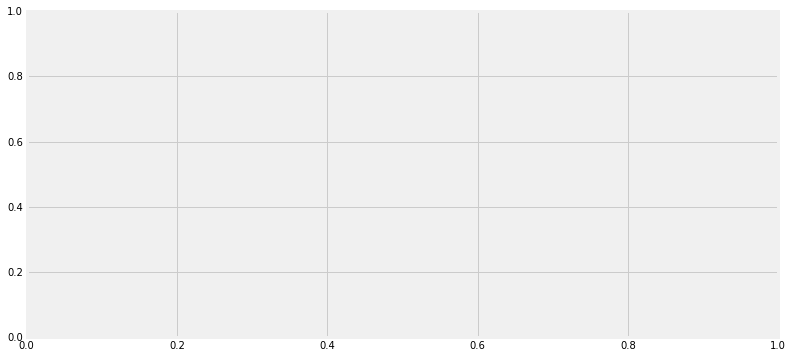

In [93]:
# 원문에는 client_bureau_balance_counts_mean 을 사용하고 있지만 해당 변수가 없어,
# 'client_bureau_balance_MONTHS_BALANCE_count_mean'으로 대체

kde_target(var_name='client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

ValueError: array must not contain infs or NaNs

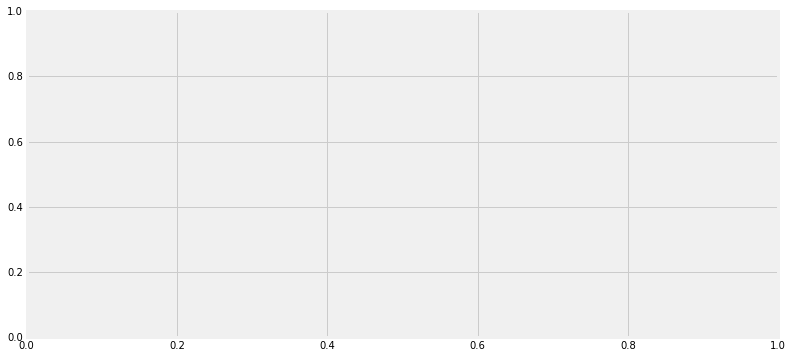

In [94]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

###### colinear Variables

목표값(target)과 변수간의 상관계수만 계산하는 것이 아닌, 각 변수간 상관계수까지 계산할 수 있습니다. 이러한 방법은 제거해야 할 수도 있는 collinear관계들을 가지는 변수들이 있는지 여부를 알려줍니다.

0.8 이상의 상관계수를 가지는 변수들을 찾아보도록 하겠습니다.

In [97]:
#임계치 설정
threshold = 0.8

#상관계수가 높은 변수들을 저장하기 위한 빈 dictionary 생성
above_threshold_vars = {}

#각각의 칼럼마다 임계치 이상의 변수들을 저장
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

높은 상관관계를 가지는 변수들의 쌍에 대해서, 하나의 변수만을 제거해야 합니다. 아래의 코드는 각각의 쌍에서 한개의 변수들만을 저장하는 set을 만드는 역할을 수행합니다.

In [99]:
# 제거할 column들 및 이미 검사된 column들의 목록을 저장위한 list 생성
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# columns 및 높은 상관관계를 가지는 columns를 따라 반복문 실행
# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    
    # 이미 검사된 column 저장
    # keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
           # 각 쌍중 하나의 column만을 제거
           if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key) 
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  130



이제 훈련용 데이터와 테스트 데이터에서 column들을 제거할 수 있습니다. 다만, column들을 제거한 데이터와 그렇지 않은 데이터로부터의 성능을 비교해보아야 합니다.(앞서 저장한 csv 파일을 활용할 수 있습니다.)

In [100]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 203)
Testing Corrs Removed Shape:  (48744, 202)


In [101]:

train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

In [102]:
pip install pandas-profiling

     |████████████████████████████████| 133kB 231kB/s eta 0:00:01
     |████████████████████████████████| 614kB 53.3MB/s eta 0:00:01
     |████████████████████████████████| 6.3MB 711kB/s eta 0:00:011
     |████████████████████████████████| 3.5MB 711kB/s eta 0:00:011
     |████████████████████████████████| 20.2MB 731kB/s eta 0:00:01     |█████████████████████████████   | 18.2MB 937kB/s eta 0:00:03
     |████████████████████████████████| 768kB 55.3MB/s eta 0:00:01


     |████████████████████████████████| 194kB 58.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 27.3MB/s eta 0:00:01
     |████████████████████████████████| 51kB 24.8MB/s eta 0:00:01
     |████████████████████████████████| 747kB 58.4MB/s eta 0:00:01
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=98668a20fc20e4c957245877cb5fc1c675866271bd6c73e4bdad335c08e9576e
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp35-none-any.whl size=27085 sha256=4d3896465745971928f7d3b14999cfd9b2a314a595aa73bce8c8ec4b4f38b145
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for confuse: filename=confuse-1.0.0-cp35-none-any.whl size=17487 sha256=418b7ca723ced61417e3e26f62370b8c0977937b3470eae879e9e18497ad311f
  Stored in directory: /root/.cache/pi

In [ ]:
import numpy as np
import pandas as pd
import pandas_profiling

df = pd.DataFrame(
np.random)